# WGAN

A short easy to read implementation of a Wasserstein GAN on CelebA data.

Origional paper: https://arxiv.org/abs/1701.07875

Many tips and improvements: https://arxiv.org/abs/1704.00028

If you don't have access to a GPU you will have to manually remove all calls of the PyTorch '.cuda()' method before running.

Also I would like to draw your attention to this repository, https://github.com/caogang/wgan-gp, which was a lot of help in diagnosing problems in my code.

In [1]:
#Import Libraries

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.autograd as ag
import torch.functional as F
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Some defines, the batch size was chosen since it's the largest my GPU can handle without running out of memory.

Define the generator and discriminator networks.

I based the architecture on the fastai lesson on WGAN's. They are designed to be agnostic as to size untill they are initialised so they can be tried with different datasets.

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn = True, pad = None):
        super().__init__()
        if not pad: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding = pad, bias = False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace = True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers = 0):
        super().__init__()
        assert isize % 16 == 0, 'isize has to be a multiple of 16'
        
        self.initial = ConvBlock(nc, ndf, 4, 2, bn = False)
        csize, cndf = isize/2, ndf
        
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1) for t in range(n_extra_layers)])
        
        bulk_layers = []
        while csize > 4:
            bulk_layers.append(ConvBlock(cndf, 2*cndf, 4, 2))
            cndf *=2
            csize /=2
        self.bulk=nn.Sequential(*bulk_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding = 0, bias = False)
    
    def forward(self, x):
        x = self.initial(x)
        x = self.extra(x)
        x = self.bulk(x)
        return self.final(x).mean(0).view(1)

In [4]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, 'isize has to be a multiple of 16'
        
        cngf, tisize = ngf//2, 4
        while tisize != isize // 2: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]
        
        csize, cndf = 4, cngf
        while csize < isize // 2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2
        
        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return torch.tanh(self.features(x))

Define the sizes of image we'll use and the dimension of the noise.

In [6]:
img_size = 32
noise_size = 100

Transforms. The normalisation takes the mean and sd of the data not the desired mean and sd!! That caused me no end of pain working out!

In [7]:
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5]*3, [0.5]*3)])

I put all of the data in a single subfolder called '0' to act as a dummy label for ImageFolder.

In [8]:
path = 'D:\datasets\CelebA'

dataset = ImageFolder(path, transform)

Send generator and discriminator to the GPU

In [9]:
gen = Generator(img_size, noise_size, 3, 64, 1).cuda()
dis = Discriminator(img_size, 3, 64, 1).cuda()

Define the number of discriminator steps for each generator step and the optimisation hyperparameters. lam is the coefficient of the gradient penalty term

In [10]:
lr = 0.0001
betas = (0.5, 0.9)
lam = 10

We use the adam optimiser after the second paper referenced at the top.

In [11]:
dis_opt = optim.Adam(dis.parameters(), lr = lr, betas = betas)
gen_opt = optim.Adam(gen.parameters(), lr = lr, betas = betas)

Gradient penalty term

In [12]:
def grad_pen(dis, real, fake):
    alpha = torch.rand(real.size(0), 1).cuda()
    alpha = alpha.expand(real.size(0), 3*img_size*img_size)
    alpha = alpha.view(real.shape)
    
    interpolated_data = alpha * real.detach() + (1-alpha)*fake.detach()
    interpolated_data.cuda().requires_grad_(True)
    
    dis_inter = dis(interpolated_data)
    
    grads = ag.grad(dis_inter, interpolated_data, 
                   grad_outputs = torch.ones(dis_inter.size()).cuda(),
                   create_graph = True,
                   retain_graph = True,
                   only_inputs = True)[0]
    
    grads = grads.view(grads.size(0), -1)
    
    return ((grads.norm(2, dim = 1) - 1)**2).mean()

We'll just store the losses in lists. This is probably not the most efficent way but training only takes ~3 hours and most of the action is happening in the GPU memory so it's not too bad.

In [13]:
dis_loss_signal = []
gen_loss_signal = []

Now the training loop. We sample from the data with replacement but I don't think this makes much difference.

In [14]:
num_iters = 20000
batch_size = 4
critic_iters = 5

for i in tqdm(range(num_iters)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for i, data in enumerate(dataloader):
        if i == critic_iters: break
        
        real, _ = data
        real = real.cuda()
        
        for param in dis.parameters():
            param.requires_grad = True
        
        dis.zero_grad()
        
        noise = torch.randn(real.size(0), noise_size, 1, 1).cuda()
        
        ims_fake = gen(noise)
        ims_fake.detach()
        
        dis_fake = dis(ims_fake)
        dis_real = dis(real)
        
        real_loss = torch.mean(dis_real)
        
        fake_loss = torch.mean(dis_fake)
        
        grad_pen_loss = grad_pen(dis, real, ims_fake)*lam
        
        dis_loss = -real_loss+fake_loss+grad_pen_loss
        dis_loss.backward()
        
        dis_opt.step()
        
        dis_loss_signal += [dis_loss.detach().cpu().numpy()]
        
#        for param in dis.parameters():
#            param.data.clamp_(-0.01, 0.01)
        
        del real, noise, dis_fake, dis_real, dis_loss, ims_fake
        
    
    for param in dis.parameters():
        param.requires_grad = False
    
    gen.zero_grad()
    
    noise = torch.randn(batch_size, noise_size, 1, 1).cuda()
    gen_loss = -torch.mean(dis(gen(noise)))
    
    gen_loss.backward()
    gen_opt.step()
    
    gen_loss_signal += [gen_loss.detach().cpu().numpy()]
    
    del noise, gen_loss
        
#        if i % 10 == 0:
#            print("minibatch: ", i)

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

Discriminator Loss

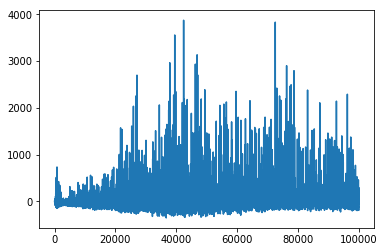

In [15]:
plt.plot(dis_loss_signal)
plt.show()

Generator Loss

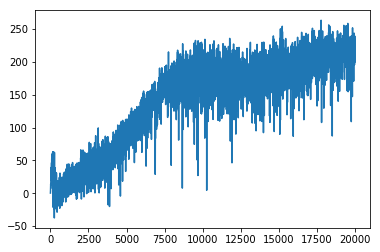

In [16]:
plt.plot(gen_loss_signal)
plt.show()

Save/Load

In [17]:
torch.save(gen.state_dict(), 'WGAN_gen_weights.pth')
torch.save(dis.state_dict(), 'WGAN_dis_weights.pth')

In [18]:
dis.load_state_dict(torch.load('WGAN_dis_weights.pth'))
gen.load_state_dict(torch.load('WGAN_gen_weights.pth'))

Some examples of generated images

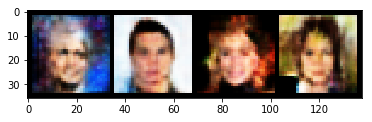

In [23]:
noise = torch.randn(4, noise_size, 1, 1).cuda()

fake_ims = gen(noise)
grid = make_grid(0.5*fake_ims.data+0.5).cpu()

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()

Looks pretty good!

And some examples of real images for comparison

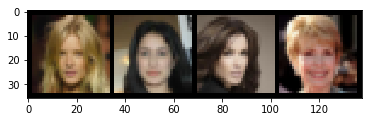

In [20]:
real = next(iter(dataloader))[0][:4]

grid = make_grid(0.5*real.data+0.5).cpu()

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()